In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"farhanhamzah","key":"eb51f66ce1088b24ad1d5a4dab424e33"}'}

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d sinakaraji/covid-vaccination-vs-death

  0% 0.00/705k [00:00<?, ?B/s]
100% 705k/705k [00:00<00:00, 47.3MB/s]


In [6]:
import os
import zipfile
# Import all required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

# Importing layers from keras. Use LSTM for input layer, and Dense for hidden and output layer
from keras.layers import Dense, LSTM, Dropout, Bidirectional 
from keras.models import Sequential

# Import SGD Optimizers
from tensorflow.keras.optimizers import SGD

# Import for splitting test and training data set
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [7]:
local_zip = '/content/covid-vaccination-vs-death.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [8]:
df = pd.read_csv('/content/covid-vaccination-vs-death_ratio.csv')

In [9]:
df

,Unnamed: 0,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,New_deaths,population,ratio
0,0,Afghanistan,AFG,2021-05-11,504502.0,448878.0,55624.0,12,40194523.0,1.116764
1,1,Afghanistan,AFG,2021-05-20,547901.0,470341.0,77560.0,10,40194523.0,1.170162
2,2,Afghanistan,AFG,2021-05-24,573277.0,476367.0,96910.0,10,40194523.0,1.185154
3,3,Afghanistan,AFG,2021-05-26,590454.0,479372.0,111082.0,19,40194523.0,1.192630
4,4,Afghanistan,AFG,2021-05-27,593313.0,479574.0,113739.0,14,40194523.0,1.193133
...,...,...,...,...,...,...,...,...,...,...
24174,24174,Zimbabwe,ZWE,2021-11-15,6190303.0,3484207.0,2706096.0,1,15183882.0,22.946747
24175,24175,Zimbabwe,ZWE,2021-11-16,6228119.0,3515140.0,2712979.0,0,15183882.0,23.150470
24176,24176,Zimbabwe,ZWE,2021-11-18,6310431.0,3583256.0,2727175.0,1,15183882.0,23.599077
24177,24177,Zimbabwe,ZWE,2021-11-19,6362499.0,3625221.0,2737278.0,0,15183882.0,23.875456


In [10]:
#define values
indonesia = ["Indonesia"]

#drop rows that contain any value in the list
df = df[df.country.isin(indonesia) == True]
df

,Unnamed: 0,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,New_deaths,population,ratio
9680,9680,Indonesia,IDN,2021-01-28,373786.0,368318.0,5468.0,476,277477532.0,0.132738
9681,9681,Indonesia,IDN,2021-01-29,416299.0,405012.0,11287.0,187,277477532.0,0.145962
9682,9682,Indonesia,IDN,2021-01-30,502955.0,482145.0,20810.0,210,277477532.0,0.173760
9683,9683,Indonesia,IDN,2021-01-31,515681.0,493133.0,22548.0,270,277477532.0,0.177720
9684,9684,Indonesia,IDN,2021-02-01,574938.0,539532.0,35406.0,279,277477532.0,0.194442
...,...,...,...,...,...,...,...,...,...,...
9937,9937,Indonesia,IDN,2021-11-16,216663555.0,131292871.0,85370684.0,15,277477532.0,47.316577
9938,9938,Indonesia,IDN,2021-11-17,218286093.0,132006377.0,86279716.0,13,277477532.0,47.573717
9939,9939,Indonesia,IDN,2021-11-18,218409909.0,132073986.0,86335923.0,11,277477532.0,47.598083
9940,9940,Indonesia,IDN,2021-11-19,221362168.0,133402051.0,87960117.0,5,277477532.0,48.076704


In [11]:
#Convert Data Types
df['date'] = pd.to_datetime(df['date'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262 entries, 9680 to 9941
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Unnamed: 0               262 non-null    int64         
 1   country                  262 non-null    object        
 2   iso_code                 262 non-null    object        
 3   date                     262 non-null    datetime64[ns]
 4   total_vaccinations       262 non-null    float64       
 5   people_vaccinated        262 non-null    float64       
 6   people_fully_vaccinated  262 non-null    float64       
 7   New_deaths               262 non-null    int64         
 8   population               262 non-null    float64       
 9   ratio                    262 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(2)
memory usage: 22.5+ KB


In [13]:
# Print banyaknya vaksinasi di seluruh area Jawa Timur dari waktu ke waktu 
data_graph = df.groupby(['date', 'country'])['ratio'].max().reset_index()
data_graph.sort_values(by="date")

data_graph['date'] = pd.to_datetime(data_graph['date'])
data_graph

,date,country,ratio
0,2021-01-28,Indonesia,0.132738
1,2021-01-29,Indonesia,0.145962
2,2021-01-30,Indonesia,0.173760
3,2021-01-31,Indonesia,0.177720
4,2021-02-01,Indonesia,0.194442
...,...,...,...
257,2021-11-16,Indonesia,47.316577
258,2021-11-17,Indonesia,47.573717
259,2021-11-18,Indonesia,47.598083
260,2021-11-19,Indonesia,48.076704


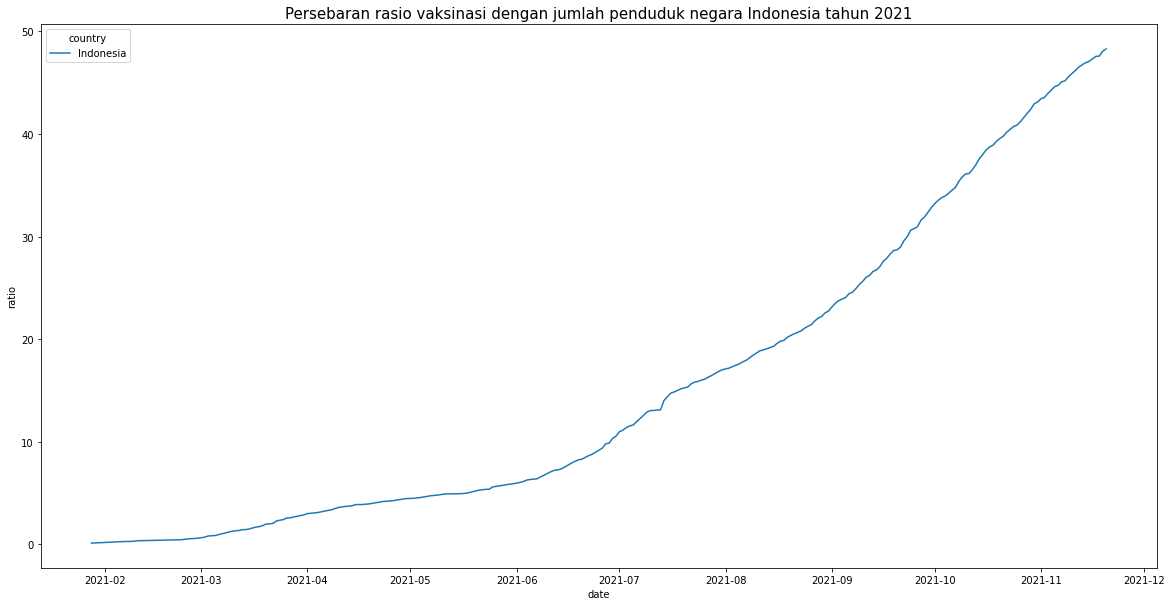

In [14]:
sorted_data_graph = data_graph.sort_values(by ='date',ascending=True)

plt.figure(figsize=(20,10))
sns.lineplot(x="date", y="ratio", data=sorted_data_graph, hue='country')
plt.title('Persebaran rasio vaksinasi dengan jumlah penduduk negara Indonesia tahun 2021',fontsize=15);

In [15]:
minMAE = (sorted_data_graph['ratio'].max() - sorted_data_graph['ratio'].min()) * (10/100)
minMAE

4.816847333066232

In [16]:
#Variables for training
cols = list(sorted_data_graph)[2:7]

df_cols = sorted_data_graph[cols].astype(float)

In [17]:
#LSTM used sigmoid and tanh that are sensitive to magnitude so values need to be normalized
#normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_cols)
df_cols_scaled = scaler.transform(df_cols)

In [18]:
dates = sorted_data_graph['date'].values
ratio = sorted_data_graph['ratio'].values

In [19]:
dates = np.asarray(dates).astype('float32')
ratio = np.asarray(ratio).astype('float32')

In [20]:
#As required for LSTM networks, require to reshape an input data into n_samples x timesteps
#In this example, the n_features is 2. I will make timesteps = 3
#With this, the resultant n_samples is 5 (as the input data has 9 rows)
trainX = []
trainY = []

n_future = 1 #Number of days I want to predict into the future
n_past = 14 # Number of past days I want to use to predict the future


for i in range(n_past, len(df_cols_scaled) - n_future+1):
  trainX.append(df_cols_scaled[i - n_past:i, 0:df_cols.shape[1]])
  trainY.append(df_cols_scaled[i + n_future - 1:i + n_future,0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape)) #holding 14 days that are looking back and 5 variables that we got
print('trainY shape == {}.'.format(trainY.shape)) # 1 is the day after n_past

trainX shape == (248, 14, 1).
trainY shape == (248, 1).


In [21]:
 model = tf.keras.models.Sequential([
                                     tf.keras.layers.LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True),
                                     tf.keras.layers.LSTM(32, activation='relu', return_sequences=False),
                                     tf.keras.layers.Dropout(0.2),
                                     tf.keras.layers.Dense(32, activation="relu"),
                                     tf.keras.layers.Dense(trainY.shape[1])    
                                   ])
 
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
  
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [22]:
#Membuat fungsi callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<0.1):
      print("\nmae kurang dari 10%")
      self.model.stop_training = True
callbacks = myCallback()

In [23]:
#Training Model
history = model.fit(trainX, trainY, batch_size=16, validation_split=0.2, epochs=400, verbose=2, callbacks=[callbacks])

Epoch 1/400
13/13 - 3s - loss: 0.2758 - mae: 0.6535 - val_loss: 1.1532 - val_mae: 1.6532 - 3s/epoch - 214ms/step
Epoch 2/400
13/13 - 0s - loss: 0.2727 - mae: 0.6496 - val_loss: 1.1580 - val_mae: 1.6580 - 156ms/epoch - 12ms/step
Epoch 3/400
13/13 - 0s - loss: 0.2685 - mae: 0.6447 - val_loss: 1.1635 - val_mae: 1.6635 - 157ms/epoch - 12ms/step
Epoch 4/400
13/13 - 0s - loss: 0.2644 - mae: 0.6399 - val_loss: 1.1688 - val_mae: 1.6688 - 156ms/epoch - 12ms/step
Epoch 5/400
13/13 - 0s - loss: 0.2605 - mae: 0.6353 - val_loss: 1.1746 - val_mae: 1.6746 - 151ms/epoch - 12ms/step
Epoch 6/400
13/13 - 0s - loss: 0.2568 - mae: 0.6306 - val_loss: 1.1797 - val_mae: 1.6797 - 171ms/epoch - 13ms/step
Epoch 7/400
13/13 - 0s - loss: 0.2532 - mae: 0.6264 - val_loss: 1.1848 - val_mae: 1.6848 - 157ms/epoch - 12ms/step
Epoch 8/400
13/13 - 0s - loss: 0.2504 - mae: 0.6232 - val_loss: 1.1900 - val_mae: 1.6900 - 148ms/epoch - 11ms/step
Epoch 9/400
13/13 - 0s - loss: 0.2473 - mae: 0.6194 - val_loss: 1.1940 - val_mae: 

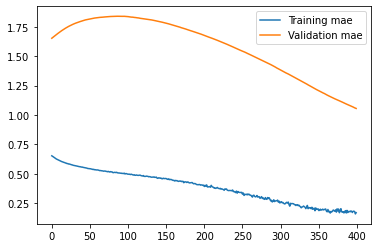

In [24]:
#Plot mae
plt.plot(history.history['mae'], label='Training mae')
plt.plot(history.history['val_mae'], label='Validation mae')
plt.legend()

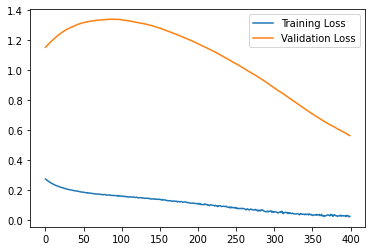

In [25]:
#Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

In [76]:
#Start with the last day in training date and predict future
n_future = 248 #Redefining n_future to extend prediction dates beyond original n_future dates
forecast_period_dates = pd.date_range(list(sorted_data_graph['date'])[-30], periods=n_future, freq='1d').tolist()

print(forecast_period_dates)

[Timestamp('2021-10-22 00:00:00', freq='D'), Timestamp('2021-10-23 00:00:00', freq='D'), Timestamp('2021-10-24 00:00:00', freq='D'), Timestamp('2021-10-25 00:00:00', freq='D'), Timestamp('2021-10-26 00:00:00', freq='D'), Timestamp('2021-10-27 00:00:00', freq='D'), Timestamp('2021-10-28 00:00:00', freq='D'), Timestamp('2021-10-29 00:00:00', freq='D'), Timestamp('2021-10-30 00:00:00', freq='D'), Timestamp('2021-10-31 00:00:00', freq='D'), Timestamp('2021-11-01 00:00:00', freq='D'), Timestamp('2021-11-02 00:00:00', freq='D'), Timestamp('2021-11-03 00:00:00', freq='D'), Timestamp('2021-11-04 00:00:00', freq='D'), Timestamp('2021-11-05 00:00:00', freq='D'), Timestamp('2021-11-06 00:00:00', freq='D'), Timestamp('2021-11-07 00:00:00', freq='D'), Timestamp('2021-11-08 00:00:00', freq='D'), Timestamp('2021-11-09 00:00:00', freq='D'), Timestamp('2021-11-10 00:00:00', freq='D'), Timestamp('2021-11-11 00:00:00', freq='D'), Timestamp('2021-11-12 00:00:00', freq='D'), Timestamp('2021-11-13 00:00:00'

In [77]:
forecast = model.predict(trainX[-n_future:])

In [78]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, just copy the values 5 times and discard them after inverse transform
forecast_copies = np.repeat(forecast, df_cols.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [81]:
#Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
  forecast_dates.append(time_i.date())

In [82]:
df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'ratio':y_pred_future})
df_forecast['date'] = pd.to_datetime(df_forecast['date'])

print('5 Baris Teratas:\n', df_forecast.head())
print('\n5 Baris Terbawah:\n', df_forecast.tail())
print('\nShape Dataset:\n', df_forecast.shape)

5 Baris Teratas:
         date     ratio
0 2021-10-22  3.695027
1 2021-10-23  3.701135
2 2021-10-24  3.707476
3 2021-10-25  3.713484
4 2021-10-26  3.719356

5 Baris Terbawah:
           date      ratio
243 2022-06-22  27.260660
244 2022-06-23  27.326563
245 2022-06-24  27.390179
246 2022-06-25  27.450315
247 2022-06-26  27.510389

Shape Dataset:
 (248, 2)


In [83]:
original = sorted_data_graph[['date', 'ratio']]
original['date'] = pd.to_datetime(original['date'])
original = original.loc[original['date'] >= '2021-01-28']

print('5 Baris Teratas:\n', original.head())
print('\n5 Baris Terbawah:\n', original.tail())
print('\nShape Dataset:\n', original.shape)

5 Baris Teratas:
         date     ratio
0 2021-01-28  0.132738
1 2021-01-29  0.145962
2 2021-01-30  0.173760
3 2021-01-31  0.177720
4 2021-02-01  0.194442

5 Baris Terbawah:
           date      ratio
257 2021-11-16  47.316577
258 2021-11-17  47.573717
259 2021-11-18  47.598083
260 2021-11-19  48.076704
261 2021-11-20  48.301211

Shape Dataset:
 (262, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


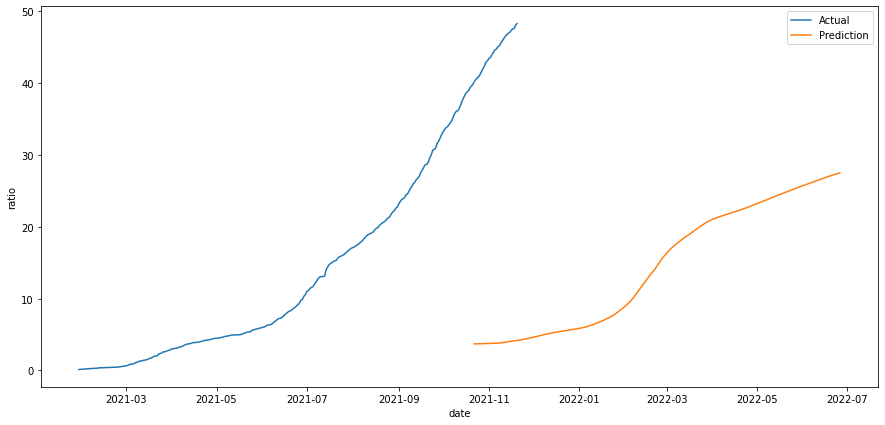

In [84]:
fig, ax = plt.subplots(figsize = (15, 7))

sns.lineplot(ax = ax, x='date', y='ratio', data=original)
sns.lineplot(ax = ax, x='date', y='ratio', data=df_forecast)
plt.legend(labels=["Actual","Prediction"])

In [85]:
model.save('ratio_vaccination.h5')

In [86]:
from google.colab import files
files.download("ratio_vaccination.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>